In [1]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
import xgboost as xgb
import numpy as np
df = pd.read_csv('data/VN_House_price_Clean2.csv')

In [2]:
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split

# -----------------------------
# 1. Feature & Target
# -----------------------------
num_features = ['Area', 'Access Road', 'Floors', 'Bedrooms', 'Bathrooms', 'Frontage']
cat_features = ['City', 'District', 'Legal status', 'Furniture state']

feature_cols = num_features + cat_features
target = "Price"

X = df[feature_cols].copy()
y = df[target]

# -----------------------------
# 2. LabelEncode categorical
# -----------------------------
label_encoders = {}

for col in cat_features:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col])
    label_encoders[col] = le  # lưu encoder nếu cần inverse_transform về sau

# -----------------------------
# 3. Scale numeric ONLY
# -----------------------------
scaler = StandardScaler()
X[num_features] = scaler.fit_transform(X[num_features])

# -----------------------------
# 4. Train/Test split
# -----------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


In [3]:
# ==========================================================
# 5. MODEL 1: XGBOOST
# ==========================================================
xgb_reg = xgb.XGBRegressor(
    n_estimators=500, 
    max_depth=6, 
    learning_rate=0.05,
    subsample=0.8, 
    colsample_bytree=0.8, 
    random_state=42
)
xgb_reg.fit(X_train, y_train)

y_pred_xgb = xgb_reg.predict(X_test)

rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)

print("===== XGBoost =====")
print(f"RMSE: {rmse_xgb:.2f}")
print(f"MAE:  {mae_xgb:.2f}")
print(f"R²:   {r2_xgb:.4f}\n")

===== XGBoost =====
RMSE: 1.32
MAE:  0.99
R²:   0.6488



In [4]:
# ==========================================================
# 6. MODEL 2: RANDOM FOREST
# ==========================================================
rf_reg = RandomForestRegressor(
    n_estimators=500,
    max_depth=15,
    random_state=42
)
rf_reg.fit(X_train, y_train)

y_pred_rf = rf_reg.predict(X_test)

rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
mae_rf = mean_absolute_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print("===== Random Forest =====")
print(f"RMSE: {rmse_rf:.2f}")
print(f"MAE:  {mae_rf:.2f}")
print(f"R²:   {r2_rf:.4f}\n")

===== Random Forest =====
RMSE: 1.42
MAE:  1.06
R²:   0.5926



In [8]:
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
import numpy as np

# =============================
# 1. XGBoost model
# =============================
xgb_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    random_state=42
)

# =============================
# 2. Param grid rút gọn
# =============================
# param_grid = {
#     'n_estimators': [400, 700],
#     'max_depth': [5, 7],
#     'learning_rate': [0.03, 0.05],
#     'subsample': [0.8, 1.0],
#     'colsample_bytree': [0.8, 1.0],
# }
# =============================
# 2. Param grid nâng cao
# =============================
param_grid = {
    'n_estimators': [800, 1200],
    'learning_rate': [0.02, 0.03],
    'max_depth': [5, 7, 9],
    'min_child_weight': [1, 3, 5],
    'subsample': [0.7, 0.85],
    'colsample_bytree': [0.7, 0.85],
    'reg_alpha': [0, 0.1],
    'reg_lambda': [1, 2],
}

# =============================
# 3. GridSearchCV
# =============================
grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    scoring='r2',
    cv=3,
    verbose=2,
    n_jobs=-1
)

# Fit
grid_search.fit(X_train, y_train)

# =============================
# 4. Kết quả tốt nhất
# =============================
print("Best parameters found:", grid_search.best_params_)
print("Best R² score (CV):", grid_search.best_score_)

# Dự đoán trên test set
best_xgb = grid_search.best_estimator_
y_pred_best = best_xgb.predict(X_test)

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

rmse_best = np.sqrt(mean_squared_error(y_test, y_pred_best))
mae_best = mean_absolute_error(y_test, y_pred_best)
r2_best = r2_score(y_test, y_pred_best)

print("\n===== Optimized XGBoost (GridSearch) =====")
print(f"RMSE: {rmse_best:.2f}")
print(f"MAE:  {mae_best:.2f}")
print(f"R²:   {r2_best:.4f}")

Fitting 3 folds for each of 576 candidates, totalling 1728 fits
Best parameters found: {'colsample_bytree': 0.85, 'learning_rate': 0.02, 'max_depth': 7, 'min_child_weight': 1, 'n_estimators': 1200, 'reg_alpha': 0.1, 'reg_lambda': 1, 'subsample': 0.85}
Best R² score (CV): 0.6499905932321908

===== Optimized XGBoost (GridSearch) =====
RMSE: 1.31
MAE:  0.97
R²:   0.6528


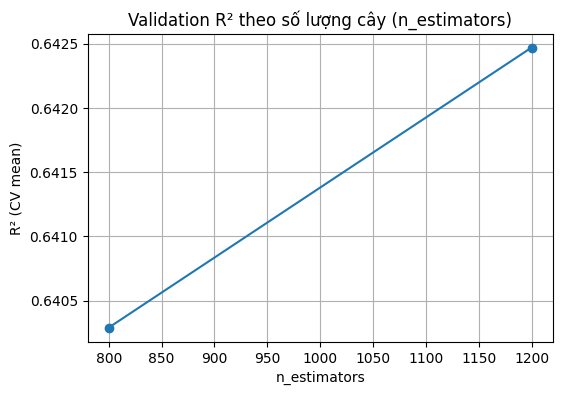

In [17]:
import matplotlib.pyplot as plt
import pandas as pd

# Lưu cv_results thành DataFrame để tiện xử lý
cv_df = pd.DataFrame(grid_search.cv_results_)

# Lấy mean_test_score theo số lượng cây
scores_tree = cv_df.groupby("param_n_estimators")["mean_test_score"].mean()

plt.figure(figsize=(6, 4))
plt.plot(scores_tree.index, scores_tree.values, marker='o')
plt.xlabel("n_estimators")
plt.ylabel("R² (CV mean)")
plt.title("Validation R² theo số lượng cây (n_estimators)")
plt.grid(True)
plt.show()


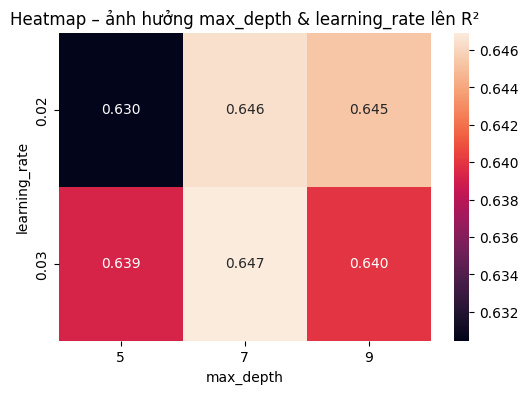

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

# Pivot bảng theo lr và depth
pivot_table = cv_df.pivot_table(
    values='mean_test_score',
    index='param_learning_rate',
    columns='param_max_depth'
)

plt.figure(figsize=(6,4))
sns.heatmap(pivot_table, annot=True, fmt=".3f")
plt.title("Heatmap – ảnh hưởng max_depth & learning_rate lên R²")
plt.xlabel("max_depth")
plt.ylabel("learning_rate")
plt.show()


In [16]:
best_xgb.save_model("xgboost_optimized1.json")


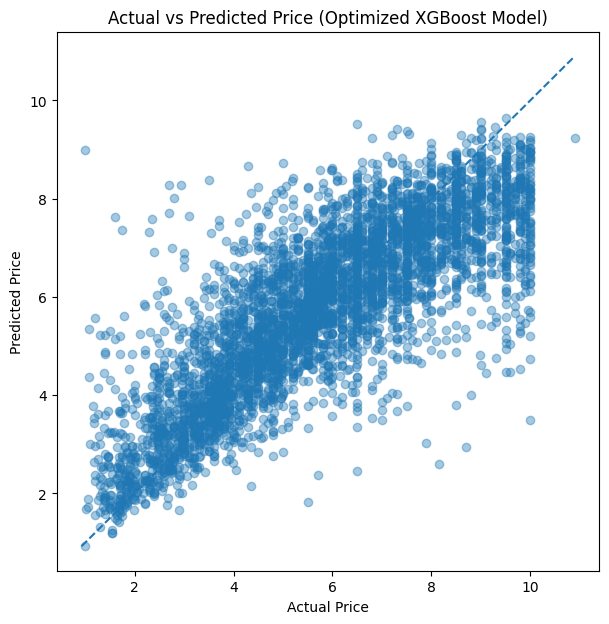

In [9]:
import matplotlib.pyplot as plt
import numpy as np

# y_test: giá thực tế
# y_pred_best: giá dự đoán từ mô hình XGBoost đã tối ưu

# Xác định min – max để vẽ đường chuẩn y = x
min_val = min(y_test.min(), y_pred_best.min())
max_val = max(y_test.max(), y_pred_best.max())

plt.figure(figsize=(7, 7))
plt.scatter(y_test, y_pred_best, alpha=0.4)
plt.plot([min_val, max_val], [min_val, max_val], linestyle='--')

plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Actual vs Predicted Price (Optimized XGBoost Model)")
plt.show()


           Feature  Importance
6             City    0.211726
3         Bedrooms    0.183270
4        Bathrooms    0.144154
2           Floors    0.119724
7         District    0.117371
0             Area    0.074845
1      Access Road    0.044729
9  Furniture state    0.036276
5         Frontage    0.034782
8     Legal status    0.033124


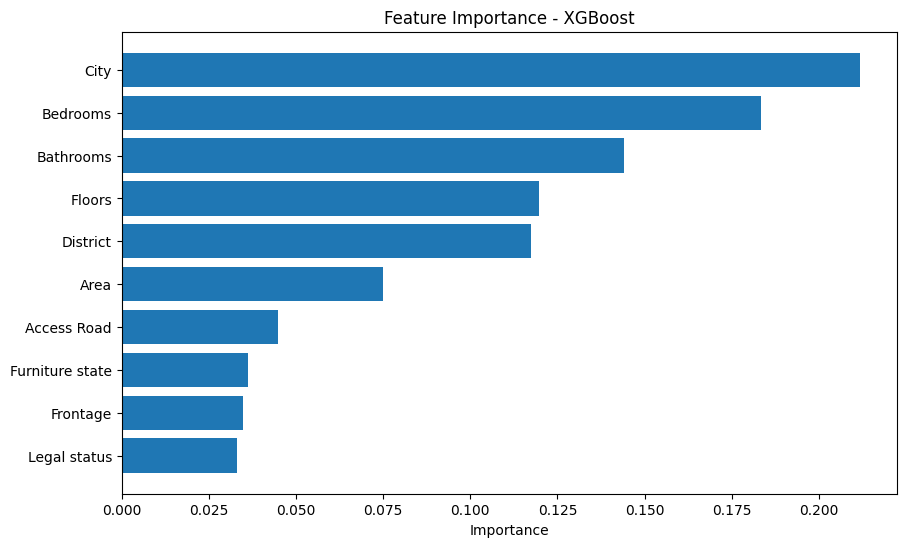

In [12]:
import matplotlib.pyplot as plt
import pandas as pd
import xgboost as xgb

# =============================
# 1. Lấy feature importance dưới dạng DataFrame
# =============================
feature_importances = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': best_xgb.feature_importances_
}).sort_values(by='Importance', ascending=False)

# In ra top 10 feature quan trọng nhất
print(feature_importances.head(20))

# =============================
# 2. Vẽ bar chart trực quan
# =============================
plt.figure(figsize=(10,6))
plt.barh(feature_importances['Feature'][:10][::-1], feature_importances['Importance'][:10][::-1])
plt.xlabel("Importance")
plt.title("Feature Importance - XGBoost")
plt.show()


In [13]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import pandas as pd

# -----------------------------
# 1. Chọn top 5 tỉnh có nhiều dữ liệu nhất
# -----------------------------
city_counts = df['City'].value_counts()
top5_cities = city_counts.head(5).index.tolist()
print("Top 5 cities:", top5_cities)

# -----------------------------
# 2. Đánh giá hiệu suất cho từng tỉnh
# -----------------------------
for city in top5_cities:
    city_label = label_encoders['City'].transform([city])[0]  # chuyển sang số nếu dùng LabelEncoder
    X_test_city = X_test[X_test['City'] == city_label]
    y_test_city = y_test[X_test_city.index]

    if len(X_test_city) == 0:
        continue

    y_pred_city = best_xgb.predict(X_test_city)

    rmse = np.sqrt(mean_squared_error(y_test_city, y_pred_city))
    mae = mean_absolute_error(y_test_city, y_pred_city)
    r2 = r2_score(y_test_city, y_pred_city)

    print(f"===== {city} =====")
    print(f"RMSE: {rmse:.2f}, MAE: {mae:.2f}, R²: {r2:.4f}\n")


Top 5 cities: ['Hồ Chí Minh', 'Hà Nội', 'Đà Nẵng', 'Bình Dương', 'Đồng Nai']
===== Hồ Chí Minh =====
RMSE: 1.27, MAE: 0.95, R²: 0.6228

===== Hà Nội =====
RMSE: 1.32, MAE: 1.01, R²: 0.5926

===== Đà Nẵng =====
RMSE: 1.30, MAE: 0.99, R²: 0.6010

===== Bình Dương =====
RMSE: 1.16, MAE: 0.75, R²: 0.6232

===== Đồng Nai =====
RMSE: 1.15, MAE: 0.78, R²: 0.7118

